# Searching for Simpson

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt2/blob/master/simpson_wages.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9, 4)

def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

In [3]:
def stretch_x(factor = 0.03):
    low, high = plt.xlim()
    space = (high-low) * factor
    plt.xlim(low - space, high + space)

In [4]:
def anchor_legend(x, y):
    """Place the upper left corner of the legend box.
    
    x: x coordinate
    y: y coordinate
    """
    plt.legend(bbox_to_anchor=(x, y), loc='upper left', ncol=1)   
    plt.tight_layout()

In [87]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

In [112]:
def plot_series_lowess(series, color, indexed=False, plot_series=True):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    if plot_series:
        x = series.index
        y = series.values
        plt.plot(x, y, 'o', color=color, alpha=0.3, label='_')
        # series.plot(linewidth=0, marker='o', color=color, alpha=0.3, label='_')
        
    smooth = make_lowess(series)
    if indexed:
        smooth /= smooth.iloc[0] / 100

    style = '--' if series.name=='all' else '-'
    smooth.plot(style=style, label=series.name, color=color)

In [74]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
len(colors)

10

In [83]:
from itertools import cycle

color_it = cycle(colors)

In [84]:

def plot_columns_lowess(table, columns, color_map=None, **options):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    color_it = cycle(colors)
    
    for col in columns:
        series = table[col]
        color = color_map[col] if color_map else next(color_it)
        plot_series_lowess(series, color, **options)

In [9]:
gss = pd.read_hdf('gss_eda.3.hdf5', 'gss0')
gss.shape

(64814, 169)

In [10]:
recode_polviews = {1:'Liberal', 
                   2:'Liberal', 
                   3:'Liberal', 
                   4:'Moderate', 
                   5:'Conservative', 
                   6:'Conservative', 
                   7:'Conservative'}

In [11]:
gss['polviews3'] = gss['polviews'].replace(recode_polviews)
gss['polviews3'].value_counts()

Moderate        21444
Conservative    19129
Liberal         14979
Name: polviews3, dtype: int64

>Generally speaking, do you usually think of yourself as a Republican, Democrat, Independent, or what?

The valid responses are:

```
0	Strong democrat
1	Not str democrat
2	Ind,near dem
3	Independent
4	Ind,near rep
5	Not str republican
6	Strong republican
7	Other party
```

You can [read the codebook for `partyid` here](https://gssdataexplorer.norc.org/projects/52787/variables/141/vshow).

In [12]:
recode_partyid = {0: 'Democrat',
                  1:'Democrat', 
                   2:'Independent', 
                   3:'Independent', 
                   4:'Independent', 
                   5:'Republican', 
                   6:'Republican', 
                   7:'Other'}

In [13]:
gss['partyid4'] = gss['partyid'].replace(recode_partyid)
gss['partyid4'].value_counts()

Independent    23404
Democrat       23308
Republican     16617
Other           1064
Name: partyid4, dtype: int64

Respondent's highest degree

```
0 	Lt high school
1 	High school
2 	Junior college
3 	Bachelor
4 	Graduate
8 	Don't know
9 	No answer
```



In [14]:
gss['degree'].value_counts()

1.0    33855
0.0    13274
3.0     9277
4.0     4465
2.0     3759
Name: degree, dtype: int64

> What is your religious preference? Is it Protestant, Catholic, Jewish, some other religion, or no religion?

```
1 	Protestant
2 	Catholic
3 	Jewish
4 	None
5 	Other
6 	Buddhism
7 	Hinduism
8 	Other eastern
9 	Moslem/islam
10 	Orthodox-christian
11 	Christian
12 	Native american
13 	Inter-nondenominational
```



In [15]:
recode_relig = {1:'Protestant', 
                   2:'Catholic', 
                   3:'Other', 
                   4:'None', 
                   5:'Other', 
                   6:'Other', 
                   7:'Other', 
                   8:'Other', 
                   9:'Other', 
                   10:'Other Christian', 
                   11:'Other Christian', 
                   12:'Other', 
                   13:'Other'}

In [16]:
gss['relig5'] = gss['relig'].replace(recode_relig)
gss['relig5'].value_counts()

Protestant         36378
Catholic           16501
None                7803
Other               2966
Other Christian      896
Name: relig5, dtype: int64

> If you were asked to use one of four names for your social class, which would you say you belong in: the lower class, the working class, the middle class, or the upper class?
 
```
1 	Lower class
2 	Working class
3 	Middle class
4 	Upper class
5 	No class
8 	Don't know
9 	No answer
0 	Not applicable
```

In [17]:
gss['class_'].value_counts()

2.0    28215
3.0    27746
1.0     3398
4.0     1969
Name: class_, dtype: int64

In [18]:
gss['age'].head()

0    60.0
1    53.0
2    72.0
3    19.0
4    44.0
Name: age, dtype: float32

In [19]:
bins = np.arange(17, 95, 5)
labels = bins[:-1] + 3

gss['age5'] = pd.cut(gss['age'], bins, labels=labels)
gss['age5'].head()

0    60
1    55
2    70
3    20
4    45
Name: age5, dtype: category
Categories (15, int64): [20 < 25 < 30 < 35 ... 75 < 80 < 85 < 90]

In [20]:
gss['age5'].value_counts().sort_index()

20    5308
25    7010
30    6776
35    6534
40    6176
45    6103
50    5763
55    5153
60    4457
65    3719
70    3044
75    2155
80    1329
85     731
90     375
Name: age5, dtype: int64

In [21]:
gss['cohort'].head()

0    1912.0
1    1919.0
2    1900.0
3    1953.0
4    1928.0
Name: cohort, dtype: float32

In [22]:
bins = np.arange(1889, 2001, 10)
labels = bins[:-1] + 1

gss['cohort10'] = pd.cut(gss['cohort'], bins, labels=labels)
gss['cohort10'].head()

0    1910
1    1910
2    1900
3    1950
4    1920
Name: cohort10, dtype: category
Categories (11, int64): [1890 < 1900 < 1910 < 1920 ... 1960 < 1970 < 1980 < 1990]

In [23]:
gss['cohort10'].value_counts().sort_index()

1890      455
1900     1717
1910     3663
1920     5959
1930     6889
1940    10463
1950    13422
1960    10123
1970     6705
1980     3821
1990     1345
Name: cohort10, dtype: int64

In [24]:
gss['year'].tail()

64809    2018
64810    2018
64811    2018
64812    2018
64813    2018
Name: year, dtype: int64

In [25]:
bins = np.arange(1970, 2025, 5)
bins

array([1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])

In [26]:
labels = bins[:-1] + 2

gss['year5'] = pd.cut(gss['year'], bins, labels=labels)
gss['year5'].tail()

64809    2017
64810    2017
64811    2017
64812    2017
64813    2017
Name: year5, dtype: category
Categories (10, int64): [1972 < 1977 < 1982 < 1987 ... 2002 < 2007 < 2012 < 2017]

In [27]:
gss['year5'].value_counts().sort_index()

1972    6091
1977    6029
1982    6466
1987    7679
1992    6115
1997    8553
2002    5577
2007    8577
2012    4512
2017    5215
Name: year5, dtype: int64

Family income on 1972-2006 surveys in constant dollars (base = 1986)

In [144]:
gss['realinc'].describe()

count     57728.000000
mean      34807.546875
std       30804.416016
min         227.000000
25%       14015.000000
50%       26015.000000
75%       44178.750000
max      162607.000000
Name: realinc, dtype: float64

In [157]:
gss['log_realinc'] = np.log10(gss['realinc'])
gss['log_realinc'].describe()

count    57728.000000
mean         4.370259
std          0.433391
min          2.356026
25%          4.146593
50%          4.415224
75%          4.645214
max          5.211139
Name: log_realinc, dtype: float64

In [159]:
temp, bins = pd.qcut(gss['log_realinc'], 10, retbins=True)
temp.head()

0    (4.415, 4.507]
1    (4.329, 4.415]
2    (2.355, 3.829]
3    (4.507, 4.587]
4    (4.587, 4.688]
Name: log_realinc, dtype: category
Categories (10, interval[float64]): [(2.355, 3.829] < (3.829, 4.07] < (4.07, 4.22] < (4.22, 4.329] ... (4.507, 4.587] < (4.587, 4.688] < (4.688, 4.861] < (4.861, 5.211]]

In [160]:
bins

array([2.35602593, 3.82872438, 4.07044411, 4.21950579, 4.32876158,
       4.41522408, 4.50650501, 4.58669996, 4.68833065, 4.86117601,
       5.2111392 ])

In [161]:
labels = np.diff(bins) / 2 + bins[:-1]
labels

array([3.09237516, 3.94958425, 4.14497495, 4.27413368, 4.37199283,
       4.46086454, 4.54660249, 4.63751531, 4.77475333, 5.03615761])

In [163]:
len(labels)

10

In [162]:
gss['log_realinc10'] = pd.qcut(gss['log_realinc'], 10, labels=labels)
gss['log_realinc10'].head()

/home/downey/anaconda3/envs/ProbablyOverthinkingIt/lib/python3.9/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/downey/anaconda3/envs/ProbablyOverthinkingIt/lib/python3.9/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0    4.460865
1    4.371993
2    3.092375
3    4.546602
4    4.637515
Name: log_realinc10, dtype: category
Categories (10, float64): [3.092375 < 3.949584 < 4.144975 < 4.274134 ... 4.546602 < 4.637515 < 4.774753 < 5.036158]

## Run Subgroups

In [28]:
xvarname = 'year'
yvarname = 'fund'
gvarname = 'relig5'

In [29]:
yvar = gss[yvarname]

In [30]:
counts = yvar.value_counts()
counts

2.0    27000
1.0    18789
3.0    16513
Name: fund, dtype: int64

In [31]:
most_common = counts.idxmax()
most_common

2.0

In [32]:
d = counts.copy()
d[:] = 0
d[most_common] = 1
d

2.0    1
1.0    0
3.0    0
Name: fund, dtype: int64

In [33]:
gss['y'] = yvar.replace(d)
gss['y'].value_counts()

0.0    35302
1.0    27000
Name: y, dtype: int64

In [34]:
gss['y'].isnull().sum()

2512

In [35]:
gss['x'] = gss[xvarname]

In [36]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=gss).fit()

Optimization terminated successfully.
         Current function value: 0.682015
         Iterations 4


In [37]:
param = results.params['x']
param

-0.010007568995860933

In [38]:
pvalue = results.pvalues['x']
pvalue

4.794654437207781e-62

In [39]:
conf_int = results.conf_int().loc['x'].values
conf_int

array([-0.01118757, -0.00882757])

In [40]:
stderr = results.bse['x']

In [41]:
def get_xresult(results):
    param = results.params['x']
    pvalue = results.pvalues['x']
    conf_int = results.conf_int().loc['x'].values
    stderr = results.bse['x']
    return [param, pvalue, stderr, conf_int]

In [42]:
columns = ['param', 'pvalue', 'stderr', 'conf_inf']
result_df = pd.DataFrame(columns=columns, dtype=object)
result_df.loc['all'] = get_xresult(results)
result_df

,param,pvalue,stderr,conf_inf
all,-0.010008,4.794654e-62,0.000602,"[-0.01118756921483927, -0.008827568776882597]"


In [43]:
grouped = gss.groupby(gvarname)

for name, group in grouped:
    print(name, len(group))

Catholic 16501
None 7803
Other 2966
Other Christian 896
Protestant 36378


In [44]:
def valid_group(group, yvarname):

    # make sure we have at least 100 values
    num_valid = group[yvarname].notnull().sum()
    if num_valid < 100:
        return False
    
    # make sure all the answers aren't the same
    counts = group[yvarname].value_counts()
    most_common = counts.max()
    
    nonplurality = num_valid - most_common
    if nonplurality < 20:
        return False
        
    return True

In [45]:
for name, group in grouped:

    if valid_group(group, yvarname):
        print(name)

Other Christian
Protestant


In [46]:
for name, group in grouped:
    if not valid_group(group, yvarname):
        continue
    print(group[yvarname].value_counts())
    results = smf.logit(formula, data=group).fit(disp=False)
    result_df.loc[name] = get_xresult(results)
    print(name, results.params['x'])

2.0    633
1.0    107
3.0     97
Name: fund, dtype: int64
Other Christian 0.3483233869681431
1.0    18678
2.0     9856
3.0     7401
Name: fund, dtype: int64
Protestant -0.01632941103830114


In [47]:
result_df

,param,pvalue,stderr,conf_inf
all,-0.010008,4.794654e-62,0.000602,"[-0.01118756921483927, -0.008827568776882597]"
Other Christian,0.348323,7.744273e-39,0.026722,"[0.2959486113167891, 0.40069816261949703]"
Protestant,-0.016329,7.699628e-72,0.000911,"[-0.018115036430687938, -0.01454378564591434]"


In [48]:
def run_subgroups(gss, xvarname, yvarname, gvarname):
    yvar = gss[yvarname]
    counts = yvar.value_counts()
    most_common = counts.idxmax()

    d = counts.copy()
    d[:] = 0
    d[most_common] = 1

    gss['y'] = yvar.replace(d)
    gss['x'] = gss[xvarname]
    #xvalues = gss['x'].unique()

    formula = 'y ~ x'
    results = smf.logit(formula, data=gss).fit(disp=False)
    #pred_df = pd.DataFrame(results.predict(xvalues), 
    #                       columns=['all'], index=xvalues)
    #print(pred_df)

    param = results.params['x']
    pvalue = results.pvalues['x']
    conf_int = results.conf_int().loc['x'].values
    stderr = results.bse['x']

    columns = ['param', 'pvalue', 'stderr', 'conf_inf']
    result_df = pd.DataFrame(columns=columns, dtype=object)
    result_df.loc['all'] = get_xresult(results)

    grouped = gss.groupby(gvarname)
    for name, group in grouped:
        if not valid_group(group, yvarname):
            continue
    
        results = smf.logit(formula, data=group).fit(disp=False)
        result_df.loc[name] = get_xresult(results)

    return result_df

In [49]:
xvarname = 'year'
yvarname = 'gunlaw'
gvarname = 'partyid4'

result_df = run_subgroups(gss, xvarname, yvarname, gvarname)
result_df

,param,pvalue,stderr,conf_inf
all,0.003234,6.733636e-05,0.000812,"[0.0016437864240885886, 0.0048249216360200945]"
Democrat,0.019363,2.944667e-38,0.001497,"[0.01642815207928425, 0.022297010084502907]"
Independent,0.002507,6.016695e-02,0.001334,"[-0.00010722608201531704, 0.005120890341326177]"
Other,-0.013315,7.678432e-03,0.004995,"[-0.02310464633097545, -0.0035258814981323633]"
Republican,-0.009366,3.977877e-09,0.001592,"[-0.012485542444758965, -0.006246924054176914]"


## Get Differences


In [50]:
stderr = result_df.loc['all', 'stderr']
stderr

0.0008115289967121576

In [51]:
params = result_df['param'].values[1:]
a = np.abs(np.subtract.outer(params, params)) / stderr
a

array([[ 0.        , 20.77035943, 40.26700849, 35.40084759],
       [20.77035943,  0.        , 19.49664905, 14.63048816],
       [40.26700849, 19.49664905,  0.        ,  4.86616089],
       [35.40084759, 14.63048816,  4.86616089,  0.        ]])

In [52]:
names = result_df.index.values[1:]
diff_df = pd.DataFrame(a, index=names, columns=names).stack()
diff_df

Democrat     Democrat        0.000000
             Independent    20.770359
             Other          40.267008
             Republican     35.400848
Independent  Democrat       20.770359
             Independent     0.000000
             Other          19.496649
             Republican     14.630488
Other        Democrat       40.267008
             Independent    19.496649
             Other           0.000000
             Republican      4.866161
Republican   Democrat       35.400848
             Independent    14.630488
             Other           4.866161
             Republican      0.000000
dtype: float64

In [53]:
diff_df.max(), diff_df.idxmax()

(40.2670084850191, ('Democrat', 'Other'))

In [54]:
def get_differences(result_df):
    stderr = result_df.loc['all', 'stderr']
    params = result_df['param'].values[1:]
    a = np.abs(np.subtract.outer(params, params)) / stderr
    names = result_df.index.values[1:]
    diff_df = pd.DataFrame(a, index=names, columns=names).stack()
    return diff_df

In [55]:
diff_df = get_differences(result_df)

In [56]:
diff_df.max(), diff_df.idxmax()

(40.2670084850191, ('Democrat', 'Other'))

In [57]:
def check_simpson(result_df):
    param_all = result_df['param'].values[0]
    params = result_df['param'].values[1:]
    mean, std = np.mean(params), np.std(params)
    stderr = result_df['stderr'].values[0]
    # if the standard deviation is small,
    # use the standard error of the estimate
    std = max(std, stderr)
    return np.abs(param_all - mean) / std

In [58]:
check_simpson(result_df)

0.27047264945760835

In [59]:
def true_simpson(result_df):
    param_all = result_df['param'].values[0]
    params = result_df['param'].values[1:]
    if param_all > 0:
        return np.all(params < 0)
    else:
        return np.all(params > 0)

In [60]:
true_simpson(result_df)

False

In [61]:
yvarnames = ['abany', 'abdefect', 'abhlth', 'abnomore', 'abpoor', 'abrape', 
            'absingle', 'affrmact', 'bible', 'cappun', 'colath', 'colcom', 
            'colhomo', 'colmil', 'colmslm', 'colrac', 'compuse', 'conarmy', 
            'conbus', 'conclerg', 'coneduc', 'confed', 'confinan', 'conjudge', 
            'conlabor', 'conlegis', 'conmedic', 'conpress', 'consci', 'contv', 
            'discaffm', 'discaffw', 'divlaw', 'divorce', 'fair', 
            'fear', 'fechld', 'fefam', 'fehire', 'fejobaff', 'fepol', 'fepresch', 
            'finrela', 'fund', 'fund16', 'god', 'grass', 'gunlaw', 'hapmar', 
            'happy', 'health', 'helpful', 'homosex', 'hunt', 'letdie1', 
            'libath', 'libcom', 'libhomo', 'libmil', 'libmslm', 'librac', 
            'life', 'memchurh', 'meovrwrk', 'nataid', 'natarms', 'natchld', 
            'natcity', 'natcrime', 'natcrimy', 'natdrug', 'nateduc', 'natenrgy', 
            'natenvir', 'natfare', 'natheal', 'natmass', 'natpark', 'natrace', 
            'natroad', 'natsci', 'natsoc', 'natspac', 'pornlaw', 
            'postlife', 'pray', 'prayer', 'premarsx', 'pres04', 'pres08', 'pres12', 
            'racmar', 'racopen', 'racpres', 'reborn', 'relexp', 'reliten', 
            'relpersn', 'res16', 'satfin', 'satjob', 'savesoul', 'sexeduc', 
            'spanking', 'spkath', 'spkcom', 'spkhomo', 'spkmil', 'spkmslm', 
            'spkrac', 'sprtprsn', 'teensex', 'trust', 'union_', 'xmarsex',
            'owngun', 'pistol', 'attend', 'relactiv']

len(yvarnames)

119

In [164]:
xvarname = 'log_realinc'
gvarname = 'polviews3'

for yvarname in yvarnames:
    result_df = run_subgroups(gss, xvarname, yvarname, gvarname)
    if check_simpson(result_df) > 2:
        flag = '*' if true_simpson(result_df) else ''
        print(xvarname, yvarname, gvarname, flag)

In [165]:
gvarnames = ['sex', 'race', 'polviews3', 'partyid4', 'relig5',
             'age5', 'year5', 'cohort10', 'class_', 'degree']

In [166]:
bad_pairs = [('year', 'year5'),
            ('age', 'age5'),
            ('cohort', 'cohort10')]

In [167]:
xvarname = 'log_realinc'

res = []
for yvarname in yvarnames:
    for gvarname in gvarnames:
        #print(xvarname, yvarname, gvarname)
        if (xvarname, gvarname) in bad_pairs:
            continue
        result_df = run_subgroups(gss, xvarname, yvarname, gvarname)
        score = check_simpson(result_df)
        if score > 2:
            flag = true_simpson(result_df)
            res.append((xvarname, yvarname, gvarname, score, flag))

In [168]:
columns = ['xvarname', 'yvarname', 'gvarname', 'score', 'flag']
leader_board = pd.DataFrame(res, columns=columns)
leader_board.sort_values(by='score', ascending=False, inplace=True)
leader_board.head(10)

,xvarname,yvarname,gvarname,score,flag
1,log_realinc,colcom,degree,12.862849,False
23,log_realinc,spkcom,degree,6.874645,False
19,log_realinc,pres08,partyid4,6.732786,False
15,log_realinc,natspac,degree,4.863178,False
8,log_realinc,libcom,degree,4.803216,False
10,log_realinc,librac,degree,4.485588,False
4,log_realinc,colmslm,degree,4.455192,False
3,log_realinc,colmil,degree,3.919362,False
18,log_realinc,pres04,partyid4,3.339512,False
12,log_realinc,natfare,race,3.324132,False


In [190]:
xvarname = 'log_realinc'
xbinned = 'log_realinc10'
yvarname = 'colcom'
gvarname = 'degree'

result_df = run_subgroups(gss, xvarname, yvarname, gvarname)

In [191]:
check_simpson(result_df)

12.862849345093586

In [192]:
true_simpson(result_df)

False

In [193]:
result_df

,param,pvalue,stderr,conf_inf
all,0.501531,7.061367e-85,0.025690,"[0.4511794374015768, 0.5518815857063435]"
0.0,0.037889,5.077047e-01,0.057199,"[-0.07421785380317864, 0.14999629285295277]"
1.0,0.036825,3.183689e-01,0.036906,"[-0.03550875101504161, 0.10915886639955735]"
2.0,0.108864,4.143488e-01,0.133368,"[-0.15253335925783582, 0.37026121583754523]"
3.0,0.096205,2.738387e-01,0.087918,"[-0.07611033131541335, 0.2685210641091154]"
4.0,0.026204,8.567345e-01,0.145149,"[-0.2582828147852127, 0.3106910986803649]"


In [194]:
series_all = gss.groupby(xbinned)['y'].mean()
series_all.name = 'all'
series_all

log_realinc10
3.092375159263611     0.495967
3.9495842456817627    0.475683
4.144974946975708     0.507492
4.274133682250977     0.533333
4.371992826461792     0.533370
4.460864543914795     0.548396
4.546602487564087     0.582060
4.637515306472778     0.600174
4.7747533321380615    0.649073
5.036157608032227     0.682771
Name: all, dtype: float32

In [195]:
table = gss.pivot_table(index=xbinned, columns=gvarname, values='y', aggfunc='mean')
table

degree,0.0,1.0,2.0,3.0,4.0
log_realinc10,,,,,
3.092375159263611,0.362466,0.570691,0.660000,0.795455,0.810811
3.9495842456817627,0.350507,0.512028,0.687898,0.684685,0.844828
4.144974946975708,0.320526,0.542339,0.684211,0.684028,0.847059
4.274133682250977,0.388889,0.528210,0.682927,0.734637,0.834951
4.371992826461792,0.358667,0.521928,0.632075,0.753880,0.726190
4.460864543914795,0.381481,0.514597,0.666667,0.748479,0.725490
4.546602487564087,0.394209,0.528090,0.766667,0.749550,0.824627
4.637515306472778,0.320242,0.562370,0.689243,0.721008,0.803977
4.7747533321380615,0.388889,0.568955,0.733333,0.738043,0.832311


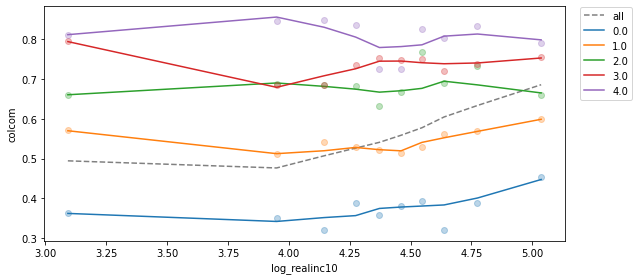

In [196]:
plot_series_lowess(series_all, 'gray', indexed=False, plot_series=False)
plot_columns_lowess(table, table.columns)

decorate(xlabel=xbinned, ylabel=yvarname)
anchor_legend(1.02, 1.02)